In [4]:
# noscript
!jupyter nbconvert --RegexRemovePreprocessor.patterns="['# ?noscript']" --TemplateExporter.exclude_markdown=True --to python compare_calibrations.ipynb

[NbConvertApp] Converting notebook compare_calibrations.ipynb to python
[NbConvertApp] Writing 4990 bytes to compare_calibrations.py


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from ridgereliability import metrics, plots
import sklearn.model_selection
import sklearn.metrics

# Compare calibration methods on CIFAR-10

We hypothesize that the PEACE metric and posterior reliability diagram will be better measures for finding an optimal post-hoc calibration method. Since PEACE is computed using full posterior balanced accuracy distributions, it takes into account the variance of probability estimates in each bin. This means using PEACE we can select a calibration method that produces probability estimates with high certainty, something we can not check with ECE.

Here, we test this hypothesis by calibrating a DenseNet trained on CIFAR-10 with temperature scaling and Platt scaling. We begin by loading a baseline model and evaluating it. Then, we do the same for calibrated models.

In [11]:
dev = [d for d in tf.config.experimental.list_logical_devices() if d.device_type=="GPU"][0]

## Load CIFAR-10

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

mean = x_train.mean()
std = x_train.std()

x_test = (x_test - mean) / (std + 1e-7)
y_test = tf.keras.utils.to_categorical(y_test)

## Train baseline uncalibrated DenseNet

We will first train two models:  
- One is trained on the full train set, and will be used as a baseline model.
- The other is trained on the smaller version of the full train set from which validation data is held-out for calibration. On this model we will apply post-hoc calibration methods.

In [12]:
with tf.device(dev.name):
    model = tf.keras.applications.DenseNet121(
        include_top=True,
        weights=None,
        classes=10,
        input_shape=[32, 32, 3]
    )

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

model.save_weights('models/model.h5')

### Train on the full train set

In [6]:
x_train = (x_train - mean) / (std + 1e-7)
y_train = tf.keras.utils.to_categorical(y_train)

with tf.device(dev.name):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [8]:
model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=1,
    validation_data=(x_test, y_test),
    steps_per_epoch=np.ceil(len(x_train)/128)
)

model.save('models/cifar10_densenet_baseline.h5')

391/391 [==============================] - 256s 654ms/step - loss: 1.5443 - accuracy: 0.4420 - val_loss: 1.3841 - val_accuracy: 0.5273


In [14]:
#noscript
baseline_model = tf.keras.models.load_model('models/cifar10_densenet_baseline.h5')

### Train on the small train set

In [9]:
x_train_s, x_val, y_train_s, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.25)

mean = x_train_s.mean()
std = x_train_s.std()

x_train_s = (x_train_s - mean) / (std + 1e-7)
y_train_s = tf.keras.utils.to_categorical(y_train_s)

x_val = (x_val - mean) / (std + 1e-7)
y_val = tf.keras.utils.to_categorical(y_val)

In [10]:
with tf.device(dev.name):
    datagen_s = tf.keras.preprocessing.image.ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images
datagen_s.fit(x_train_s)

In [11]:
model.load_weights("models/model.h5")

In [12]:
model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=1,
    validation_data=(x_test, y_test),
    steps_per_epoch=np.ceil(len(x_train)/128)
)

model.save('models/cifar10_densenet_baseline_s.h5')

391/391 [==============================] - 130s 333ms/step - loss: 1.5767 - accuracy: 0.4261 - val_loss: 1.3942 - val_accuracy: 0.5084


In [28]:
#noscript
baseline_model_s = tf.keras.models.load_model('models/cifar10_densenet_baseline_s.h5')

In [18]:
exit()

## Evaluation

In [24]:
from importlib import reload
reload(plots)

<module 'ridgereliability.plots' from '/home/maximl/Data/dev/active/ridgereliability/ridgereliability/plots.py'>

In [26]:
def evaluate_model(model, x_test, y_test):
    
    y_probs = model.predict(x_test, batch_size=128, verbose=1)
    y_probs_max = y_probs.max(axis=1)
    y_preds = y_probs.argmax(axis=1)
    y_test = y_test.argmax(axis=1)
    
    plots.posterior_reliability_diagram(y_probs_max, y_preds, y_test, bins=15)
    
    return {
        "accuracy": sklearn.metrics.accuracy_score(y_test, y_preds),
        "balanced_accuracy": sklearn.metrics.balanced_accuracy_score(y_test, y_preds),
        'ece': metrics.ece(y_probs_max, y_preds, y_test),
        'ece_balanced': metrics.ece(y_probs_max, y_preds, y_test, balanced=True),
        'peace': metrics.peace(y_probs_max, y_preds, y_test),
        'class_wise_ece': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece),
        'class_wise_ece_balanced': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.ece, balanced=True),
        'class_wise_peace': metrics.class_wise_error(y_probs, y_preds, y_test, metrics.peace)
    }

79/79 [==============================] - 7s 86ms/step


/home/maximl/.conda/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


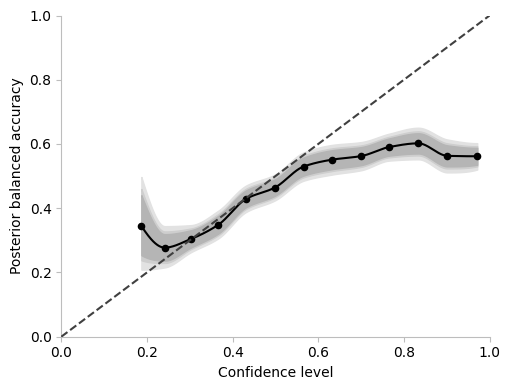

In [29]:
evaluate_model(baseline_model, x_test, y_test)

79/79 [==============================] - 7s 86ms/step


/home/maximl/.conda/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


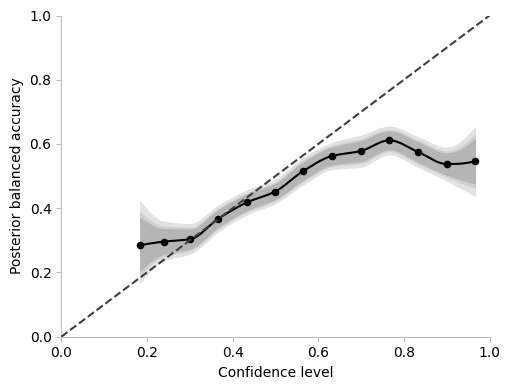

In [30]:
evaluate_model(baseline_model_s, x_test, y_test)

## Calibration